## Prepare for learning

In [ ]:
from google.colab import drive
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import ndimage
import time
from sklearn.neighbors import KNeighborsClassifier
import psutil
from sklearn.metrics import confusion_matrix
import seaborn as sn

### Load Dataset

In [ ]:
drive.mount('/content/drive')
mat = sio.loadmat('/content/drive/MyDrive/face.mat')

imgs_raw = mat['X']
labels = mat['l'][0]
print(imgs_raw.shape, labels.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2576, 520) (520,)


### Split data into train dataset and test dataset(8:2)

In [ ]:
'''
split data into test dataset and train dataset(8:2)
'''

train_idx = np.array([[True]*10]*52)
for i in train_idx:
  test_idx_tmp = np.random.choice(10, size=2, replace=False)
  i[test_idx_tmp]=False
train_idx = train_idx.flatten()
test_idx = ~ train_idx

train_imgs_raw = np.array([i[train_idx] for i in imgs_raw])
test_imgs_raw = np.array([i[test_idx] for i in imgs_raw])
train_labels = labels[train_idx]
test_labels = labels[test_idx]

print("Data Dimension")
print("train_imgs_raw : ", len(train_imgs_raw)," * ", len(train_imgs_raw[0]))
print("test_imgs_raw  : ", len(test_imgs_raw)," * ",  len(test_imgs_raw[0]))
print("train_labels : ", len(train_labels))
print("test_labels  : ", len(test_labels))

Data Dimension
train_imgs_raw :  2576  *  416
test_imgs_raw  :  2576  *  104
train_labels :  416
test_labels  :  104


## 3.1. PCA-LDA for Face Recognition

In [ ]:
def get_train_dataset(imgs_raw, num_per_class, is_replace=False):
  train_idx = np.array([[False]*10]*52)
  for i in train_idx:
    train_idx_tmp = np.random.choice(10, size=num_per_class, replace=is_replace)
    i[train_idx_tmp]=True
  train_idx = train_idx.flatten()
  
  train_imgs_raw = np.array([i[train_idx] for i in imgs_raw])
  train_labels = labels[train_idx]

  return train_imgs_raw, train_labels

In [ ]:
import sys
def PCA(train_imgs_raw, Mpca, is_feature_random=False):
  avg = np.mean(train_imgs_raw, axis=1)
  A = (train_imgs_raw.T-avg).T
  
  S_low = np.dot(A.T, A)
  start = time.time()
  m_size = sys.getsizeof(S_low)
  w_low, v_low = np.linalg.eigh(S_low)
  stop = time.time()
  v_low_to_high = np.dot(A, v_low)

  v_low_to_high = v_low_to_high/np.linalg.norm(v_low_to_high, axis=0)

  P_low = v_low_to_high.T[-Mpca:].T
  w = w_low[-Mpca:]
  if is_feature_random:
    max_idx_zero = np.where(np.isclose(w_low, 0))[0][-1]
    idx = np.random.choice(np.arange(max_idx_zero+1, w_low.shape[0]), size=Mpca, replace=False)
    P_low = v_low_to_high.T[idx].T
    w = w_low[idx]

  P = P_low

  T = stop-start

  return w, P, T, avg, m_size

In [ ]:
def PCA_LDA(train_imgs_raw, Mpca, Mlda, is_feature_random=False, num_classes=52):
  global_mean = np.mean(train_imgs_raw, axis=1)
  class_mean = []
  img_size, num_imgs = train_imgs_raw.shape
  num_img_per_class = int(num_imgs/num_classes)
  for i in range(num_classes):
    class_mean.append(np.mean(train_imgs_raw[:, i*num_img_per_class:(i+1)*num_img_per_class], axis=1))
  class_mean = np.array(class_mean)
  
  diff_between = class_mean-global_mean
  diff_within = np.array([train_imgs_raw.T[i]-class_mean[i//8] for i in range(num_imgs)])

  w, P, Tpca, avg, pca_mem = PCA(train_imgs_raw, Mpca, is_feature_random)
  W = P
  PCA_result = (w, P, Tpca, avg, pca_mem)
  Sb = np.dot(diff_between.T, diff_between)
  Sw = np.dot(diff_within.T, diff_within)

  Sb_pca = np.dot(np.dot(W.T, Sb), W)
  Sw_pca = np.dot(np.dot(W.T, Sw), W)
  Matrix_LDA = np.dot(np.linalg.inv(Sw_pca), Sb_pca)

  start = time.time()
  lda_mem = sys.getsizeof(Matrix_LDA)
  w_fisher, v_fisher = np.linalg.eigh(Matrix_LDA)
  stop = time.time()

  w_fisher = w_fisher[-Mlda:]
  v_fisher = v_fisher.T[-Mlda:].T
  Tlda = Tpca+stop-start

  Rank_Sb = np.linalg.matrix_rank(Sb, hermitian=True)
  Rank_Sw = np.linalg.matrix_rank(Sw, hermitian=True)
  Rank_Sb_pca = np.linalg.matrix_rank(Sb_pca, hermitian=True)
  Rank_Sw_pca = np.linalg.matrix_rank(Sw_pca, hermitian=True)

  Ranks = (Rank_Sb, Rank_Sw, Rank_Sb_pca, Rank_Sw_pca)
  Confusion_Matrices = (Sb+Sw, Sb_pca+Sw_pca)
  Mem = (pca_mem, lda_mem)

  PCA_LDA_result = (w_fisher, v_fisher, Tlda, Ranks, Confusion_Matrices, Mem)

  return PCA_result, PCA_LDA_result

### Fix M_lda

In [ ]:
Mpca_list = [i for i in range(1, 61)]
Mlda_list = [i for i in range(1, 61)]

classifier_PCA_25, classifier_LDA_25, test_PCA_25, test_LDA_25, v_fisher_25, P_25, avg_25 = None, None, None, None, None, None, None
classifier_PCA_50, classifier_LDA_50, test_PCA_50, test_LDA_50, v_fisher_50, P_50, avg_50 = None, None, None, None, None, None, None
perfDataInfo = []
rankDataInfo = []

print("Mlda is fixed: 50")
for Mpca in Mpca_list:
  PCA_result, PCA_LDA_result = PCA_LDA(train_imgs_raw, Mpca, 50)
  w, P, Tpca, avg, pca_mem = PCA_result

  start_time = time.time()
  train_proj_PCA = np.dot((train_imgs_raw.T-avg), P)
  test_proj_PCA = np.dot((test_imgs_raw.T-avg), P)

  for i in range(9, 0, -1):
    classifier_PCA = KNeighborsClassifier(n_neighbors = i)
    classifier_PCA.fit(train_proj_PCA, train_labels)

    train_score_PCA = classifier_PCA.score(train_proj_PCA, train_labels)
    test_score_PCA = classifier_PCA.score(test_proj_PCA, test_labels)

    w_fisher, v_fisher, Tlda, Ranks, Confusion_Matrices, Mem = PCA_LDA_result
    Rank_Sb, Rank_Sw, Rank_Sb_pca, Rank_Sw_pca = Ranks

    train_proj_LDA = np.dot(train_proj_PCA, v_fisher)
    test_proj_LDA = np.dot(test_proj_PCA, v_fisher)

    classifier_LDA = KNeighborsClassifier(n_neighbors = i)
    classifier_LDA.fit(train_proj_LDA, train_labels)

    train_score_LDA = classifier_LDA.score(train_proj_LDA, train_labels)
    test_score_LDA = classifier_LDA.score(test_proj_LDA, test_labels)

  end_time = time.time()

  if Mpca==25:
    classifier_PCA_25, classifier_LDA_25 = classifier_PCA, classifier_LDA
    test_PCA_25, test_LDA_25 = test_proj_PCA, test_proj_LDA
    v_fisher_25 = v_fisher
    P_25 = P
    avg_25 = avg
  elif Mpca==50:
    classifier_PCA_50, classifier_LDA_50 = classifier_PCA, classifier_LDA
    test_PCA_50, test_LDA_50 = test_proj_PCA, test_proj_LDA
    v_fisher_50 = v_fisher
    P_50 = P
    avg_50 = avg

  print(f"  Mpca = {Mpca}")
  print(f"    For PCA,     train score is {train_score_PCA}, test score is {test_score_PCA}, training time is {Tpca}")
  print(f"    For PCA-LDA, train score is {train_score_LDA}, test score is {test_score_LDA}, training time is {Tlda}")
  print("   Rank of scatter matricies:")
  print(f"      Without PCA, Sb is {Rank_Sb} and Sw is {Rank_Sw}")
  print(f"      With PCA,    Sb is {Rank_Sb_pca} and Sw is {Rank_Sw_pca}\n")

  perfDataInfo.append(
      {"Fixed": "Mlda = 50", "Mpca": Mpca, "Mlda": 50, "version": "PCA-LDA",
       "Training Time": end_time - start_time, "PCA Memory Usage": Mem[0], "LDA Memory Usage": Mem[1], "Score": test_score_LDA, "dataset": "test"}
  )
  rankDataInfo.append(
      {"Fixed": "Mlda = 50", "Mpca": Mpca, "Mlda": 50, "version": "Without PCA",
       "Rank(Sb)": Rank_Sb, "Rank(Sw)": Rank_Sw}
  )
  rankDataInfo.append(
      {"Fixed": "Mlda = 50", "Mpca": Mpca, "Mlda": 50, "version": "With PCA",
       "Rank(Sb)": Rank_Sb_pca, "Rank(Sw)": Rank_Sw_pca}
  )

Mlda is fixed: 50
  Mpca = 1
    For PCA,     train score is 1.0, test score is 0.04807692307692308, training time is 0.04115128517150879
    For PCA-LDA, train score is 1.0, test score is 0.04807692307692308, training time is 0.041196584701538086
   Rank of scatter matricies:
      Without PCA, Sb is 51 and Sw is 364
      With PCA,    Sb is 1 and Sw is 1

  Mpca = 2
    For PCA,     train score is 1.0, test score is 0.09615384615384616, training time is 0.03236222267150879
    For PCA-LDA, train score is 1.0, test score is 0.09615384615384616, training time is 0.032477617263793945
   Rank of scatter matricies:
      Without PCA, Sb is 51 and Sw is 364
      With PCA,    Sb is 2 and Sw is 2

  Mpca = 3
    For PCA,     train score is 1.0, test score is 0.057692307692307696, training time is 0.034979820251464844
    For PCA-LDA, train score is 1.0, test score is 0.057692307692307696, training time is 0.035062551498413086
   Rank of scatter matricies:
      Without PCA, Sb is 51 and Sw 

When Mpca is 25
<PCA-LDA confusion matrix>


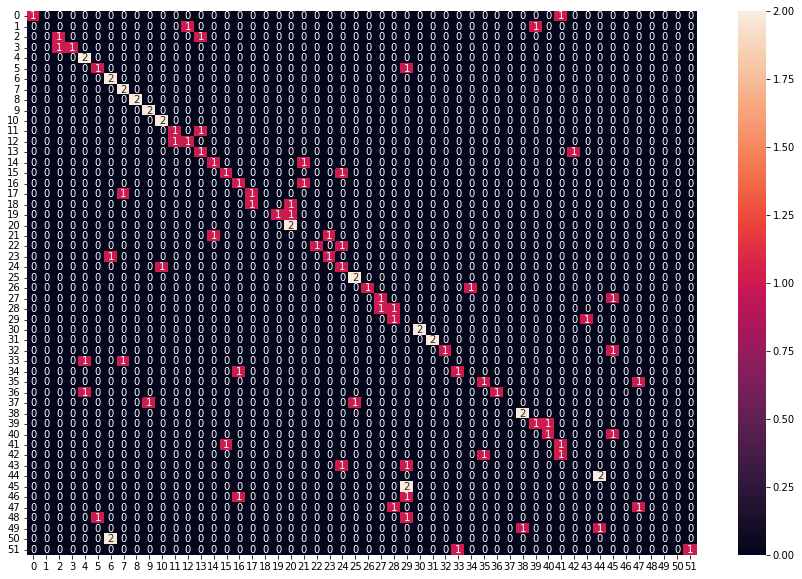

In [ ]:
print("When Mpca is 25")

preds_lda=classifier_LDA_25.predict(test_LDA_25)
print("<PCA-LDA confusion matrix>")
plt.figure(figsize = (15,10))
plt.xlabel("predicted class")
plt.ylabel("actual class")
sn.heatmap(confusion_matrix(test_labels, preds_lda), annot=True)

When Mpca is 50
<PCA-LDA confusion matrix>


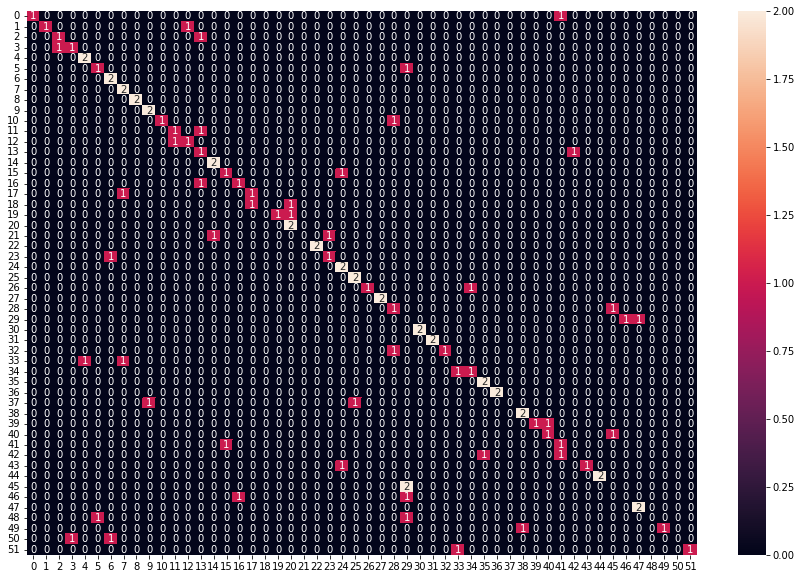

In [ ]:
print("When Mpca is 50")

preds_lda=classifier_LDA_50.predict(test_LDA_50)
print("<PCA-LDA confusion matrix>")
plt.figure(figsize = (15,10))
plt.xlabel("predicted class")
plt.ylabel("actual class")
sn.heatmap(confusion_matrix(test_labels, preds_lda), annot=True)

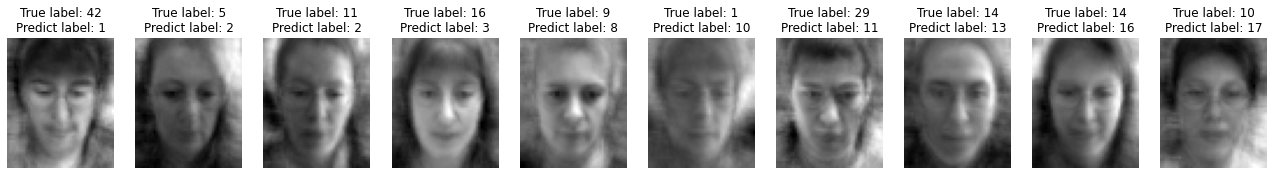

Above images are wrong predicted PCA_LDA cases



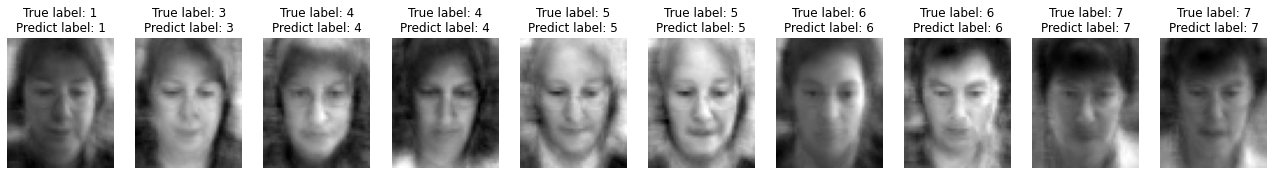

Above images are success predicted PCA_LDA cases


In [ ]:
preds_pca=classifier_PCA_50.predict(test_PCA_50)
preds_lda=classifier_LDA_50.predict(test_LDA_50)
test_reconst = np.dot(test_PCA_50, P_50.T) + avg_50

num = 10
num_right, num_wrong = num, num
right, wrong = [], []

idx=0
while((num_wrong!=0 or num_right!=0) and idx<preds_lda.shape[0]):
  if(preds_lda[idx]==test_labels[idx] and num_right!=0):
    append = (test_reconst[idx].reshape((46,56)).T, preds_lda[idx], test_labels[idx])
    right.append(append)
    num_right-=1
  if(preds_lda[idx]!=test_labels[idx] and num_wrong!=0):
    append = (test_reconst[idx].reshape((46,56)).T, preds_lda[idx], test_labels[idx])
    wrong.append(append)
    num_wrong-=1
  idx+=1

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
ax = ax.flatten()
for i in range(len(wrong)):
  ax[i].imshow(wrong[i][0], cmap = 'gist_gray')
  ax[i].axis('off')
  ax[i].set_title(f"True label: {wrong[i][1]}\nPredict label: {wrong[i][2]}")
plt.subplots_adjust(right=1)
plt.show()
print("Above images are wrong predicted PCA_LDA cases\n")

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
ax = ax.flatten()
for i in range(len(right)):
  ax[i].imshow(right[i][0], cmap = 'gist_gray')
  ax[i].axis('off')
  ax[i].set_title(f"True label: {right[i][1]}\nPredict label: {right[i][2]}")
plt.subplots_adjust(right=1)
plt.show()
print("Above images are success predicted PCA_LDA cases")

### Fix M_pca

In [ ]:
import tracemalloc

print("Mpca is fixed: 25")
for i, Mlda in enumerate(Mlda_list):
  PCA_result, PCA_LDA_result = PCA_LDA(train_imgs_raw, 25, Mlda)
  w, P, Tpca, avg, pca_mem = PCA_result

  start_time = time.time()
  for k in range(9, 0, -1):
    if(i==0):
      train_proj_PCA = np.dot((train_imgs_raw.T-avg), P)
      test_proj_PCA = np.dot((test_imgs_raw.T-avg), P)

      classifier_PCA = KNeighborsClassifier(n_neighbors = k)
      classifier_PCA.fit(train_proj_PCA, train_labels)
      tracemalloc.stop()

      train_score_PCA = classifier_PCA.score(train_proj_PCA, train_labels)
      test_score_PCA = classifier_PCA.score(test_proj_PCA, test_labels)
      print(f"  For PCA,     train score is {train_score_PCA}, test score is {test_score_PCA}, training time is {Tpca}")

    w_fisher, v_fisher, Tlda, Ranks, Confusion_Matrices, Mem = PCA_LDA_result
    Rank_Sb, Rank_Sw, Rank_Sb_pca, Rank_Sw_pca = Ranks

    train_proj_LDA = np.dot(train_proj_PCA, v_fisher)
    test_proj_LDA = np.dot(test_proj_PCA, v_fisher)

    classifier_LDA = KNeighborsClassifier(n_neighbors = k)
    tracemalloc.start()
    snapshot1 = tracemalloc.take_snapshot()
    classifier_LDA.fit(train_proj_LDA, train_labels)
    snapshot2 = tracemalloc.take_snapshot()
    top_stats = snapshot2.compare_to(snapshot1, 'lineno')
    tracemalloc.stop()

    train_score_LDA = classifier_LDA.score(train_proj_LDA, train_labels)
    test_score_LDA = classifier_LDA.score(test_proj_LDA, test_labels)

  end_time = time.time()
  print(f"  Mlda = {Mlda}")
  print(f"    For PCA-LDA, train score is {train_score_LDA}, test score is {test_score_LDA}, training time is {Tlda}")
  print("   Rank of scatter matricies:")
  print(f"      Without PCA, Sb is {Rank_Sb} and Sw is {Rank_Sw}")
  print(f"      With PCA,    Sb is {Rank_Sb_pca} and Sw is {Rank_Sw_pca}\n")

  perfDataInfo.append(
      {"Fixed": "Mpca = 25", "Mpca": 25, "Mlda": Mlda, "version": "PCA-LDA",
       "Training Time": end_time - start_time, "PCA Memory Usage": Mem[0], "LDA Memory Usage": Mem[1], "Score": test_score_LDA, "dataset": "test" } 
  )
  rankDataInfo.append(
      {"Fixed": "Mpca = 25", "Mpca": 25, "Mlda": Mlda, "version": "Without PCA",
       "Rank(Sb)": Rank_Sb, "Rank(Sw)": Rank_Sw}
  )
  rankDataInfo.append(
      {"Fixed": "Mpca = 25", "Mpca": 25, "Mlda": Mlda, "version": "With PCA",
       "Rank(Sb)": Rank_Sb_pca, "Rank(Sw)": Rank_Sw_pca}
  )

Mpca is fixed: 25
  For PCA,     train score is 0.5480769230769231, test score is 0.33653846153846156, training time is 0.03861546516418457
  For PCA,     train score is 0.5625, test score is 0.36538461538461536, training time is 0.03861546516418457
  For PCA,     train score is 0.5889423076923077, test score is 0.38461538461538464, training time is 0.03861546516418457
  For PCA,     train score is 0.5913461538461539, test score is 0.4230769230769231, training time is 0.03861546516418457
  For PCA,     train score is 0.625, test score is 0.41346153846153844, training time is 0.03861546516418457
  For PCA,     train score is 0.6730769230769231, test score is 0.41346153846153844, training time is 0.03861546516418457
  For PCA,     train score is 0.71875, test score is 0.41346153846153844, training time is 0.03861546516418457
  For PCA,     train score is 0.7307692307692307, test score is 0.40384615384615385, training time is 0.03861546516418457
  For PCA,     train score is 1.0, test sco

In [ ]:
print("Mpca is fixed: 50")
for i, Mlda in enumerate(Mlda_list):
  PCA_result, PCA_LDA_result = PCA_LDA(train_imgs_raw, 50, Mlda)
  w, P, Tpca, avg, pca_mem = PCA_result

  start_time = time.time()
  for k in range(9, 0, -1):
    if(i==0):
      train_proj_PCA = np.dot((train_imgs_raw.T-avg), P)
      test_proj_PCA = np.dot((test_imgs_raw.T-avg), P)

      classifier_PCA = KNeighborsClassifier(n_neighbors = k)
      classifier_PCA.fit(train_proj_PCA, train_labels)

      train_score_PCA = classifier_PCA.score(train_proj_PCA, train_labels)
      test_score_PCA = classifier_PCA.score(test_proj_PCA, test_labels)
      print(f"  For PCA,     train score is {train_score_PCA}, test score is {test_score_PCA}, training time is {Tpca}")

    w_fisher, v_fisher, Tlda, Ranks, Confusion_Matrices, Mem = PCA_LDA_result
    Rank_Sb, Rank_Sw, Rank_Sb_pca, Rank_Sw_pca = Ranks

    train_proj_LDA = np.dot(train_proj_PCA, v_fisher)
    test_proj_LDA = np.dot(test_proj_PCA, v_fisher)

    classifier_LDA = KNeighborsClassifier(n_neighbors = k)
    classifier_LDA.fit(train_proj_LDA, train_labels)

    train_score_LDA = classifier_LDA.score(train_proj_LDA, train_labels)
    test_score_LDA = classifier_LDA.score(test_proj_LDA, test_labels)
  end_time = time.time()

  print(f"  Mlda = {Mlda}")
  print(f"    For PCA-LDA, train score is {train_score_LDA}, test score is {test_score_LDA}, training time is {Tlda}")
  print("   Rank of scatter matricies:")
  print(f"      Without PCA, Sb is {Rank_Sb} and Sw is {Rank_Sw}")
  print(f"      With PCA,    Sb is {Rank_Sb_pca} and Sw is {Rank_Sw_pca}\n")

  perfDataInfo.append(
      {"Fixed": "Mpca = 50", "Mpca": 50, "Mlda": Mlda, "version": "PCA-LDA",
       "Training Time": end_time - start_time, "PCA Memory Usage": Mem[0], "LDA Memory Usage": Mem[1], "Score": test_score_LDA, "dataset": "test" } 
  )
  rankDataInfo.append(
      {"Fixed": "Mpca = 50", "Mpca": 50, "Mlda": Mlda, "version": "Without PCA",
       "Rank(Sb)": Rank_Sb, "Rank(Sw)": Rank_Sw}
  )
  rankDataInfo.append(
      {"Fixed": "Mpca = 50", "Mpca": 50, "Mlda": Mlda, "version": "With PCA",
       "Rank(Sb)": Rank_Sb_pca, "Rank(Sw)": Rank_Sw_pca}
  )

Mpca is fixed: 50
  For PCA,     train score is 0.5576923076923077, test score is 0.3557692307692308, training time is 0.04273676872253418
  For PCA,     train score is 0.5793269230769231, test score is 0.38461538461538464, training time is 0.04273676872253418
  For PCA,     train score is 0.6033653846153846, test score is 0.40384615384615385, training time is 0.04273676872253418
  For PCA,     train score is 0.6370192307692307, test score is 0.41346153846153844, training time is 0.04273676872253418
  For PCA,     train score is 0.6538461538461539, test score is 0.4423076923076923, training time is 0.04273676872253418
  For PCA,     train score is 0.6706730769230769, test score is 0.4519230769230769, training time is 0.04273676872253418
  For PCA,     train score is 0.7524038461538461, test score is 0.4230769230769231, training time is 0.04273676872253418
  For PCA,     train score is 0.7644230769230769, test score is 0.4230769230769231, training time is 0.04273676872253418
  For PCA, 

### Result Analysis in Figures

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type":"xy"}, {"type":"xy"}]], column_titles=["When M_lda is fixed at 50", "When M_pca is fixed at 25", "When M_pca is fixed at 50"])
fig.update_layout(title="Accuracy Score", yaxis_title="Mean Accuracy")
fig['layout']['xaxis']['title']='M_pca'
fig['layout']['xaxis2']['title']='M_lda'
fig['layout']['xaxis3']['title']='M_lda'

filtered = [data for data in perfDataInfo if "Mlda" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered], y=[data["Score"] for data in filtered], mode="lines"),
                        row=1, col=1)

filtered = [data for data in perfDataInfo if "Mpca = 25" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["Score"] for data in filtered], mode="lines"),
                        row=1, col=2)

filtered = [data for data in perfDataInfo if "Mpca = 50" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["Score"] for data in filtered], mode="lines"),
                        row=1, col=3)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type":"xy"}, {"type":"xy"}]], column_titles=["When M_lda is fixed at 50", "When M_pca is fixed at 25", "When M_pca is fixed at 50"])
fig.update_layout(title="Training Time", yaxis_title="Training Time (s)")
fig['layout']['xaxis']['title']='M_pca'
fig['layout']['xaxis2']['title']='M_lda'
fig['layout']['xaxis3']['title']='M_lda'

filtered = [data for data in perfDataInfo if "Mlda" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered], y=[data["Training Time"] for data in filtered], mode="lines"),
                        row=1, col=1)

filtered = [data for data in perfDataInfo if "Mpca = 25" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["Training Time"] for data in filtered], mode="lines"),
                        row=1, col=2)

filtered = [data for data in perfDataInfo if "Mpca = 50" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["Training Time"] for data in filtered], mode="lines"),
                        row=1, col=3)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type":"xy"}, {"type":"xy"}]], column_titles=["When M_lda is fixed at 50", "When M_pca is fixed at 25", "When M_pca is fixed at 50"])
fig.update_layout(title="Memory Usage", yaxis_title="Memory Usage (bytes)")
fig['layout']['xaxis']['title']='M_pca'
fig['layout']['xaxis2']['title']='M_lda'
fig['layout']['xaxis3']['title']='M_lda'

filtered = [data for data in perfDataInfo if "Mlda" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered], y=[data["LDA Memory Usage"] for data in filtered], mode="lines"),
                        row=1, col=1)

filtered = [data for data in perfDataInfo if "Mpca = 25" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["LDA Memory Usage"] for data in filtered], mode="lines"),
                        row=1, col=2)

filtered = [data for data in perfDataInfo if "Mpca = 50" in data["Fixed"] and "LDA" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered], y=[data["LDA Memory Usage"] for data in filtered], mode="lines"),
                        row=1, col=3)
fig.update_layout(showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type":"xy"}, {"type":"xy"}]], column_titles=["When M_lda is fixed at 50", "When M_pca is fixed at 25", "When M_pca is fixed at 50"])
fig.update_layout(title="Ranks of Between Scatter Matrices", yaxis_title="Rank(Sb)")
fig['layout']['xaxis']['title']='M_pca'
fig['layout']['xaxis2']['title']='M_lda'
fig['layout']['xaxis3']['title']='M_lda'

filtered = [data for data in rankDataInfo if "Mlda" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=1)

filtered = [data for data in rankDataInfo if "Mlda" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=1)

filtered = [data for data in rankDataInfo if "Mpca = 25" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=2)

filtered = [data for data in rankDataInfo if "Mpca = 25" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=2)

filtered = [data for data in rankDataInfo if "Mpca = 50" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=3)

filtered = [data for data in rankDataInfo if "Mpca = 50" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sb)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=3)

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "xy"}, {"type":"xy"}, {"type":"xy"}]], column_titles=["When M_lda is fixed at 50", "When M_pca is fixed at 25", "When M_pca is fixed at 50"])
fig.update_layout(title="Ranks of Within Scatter Matrices", yaxis_title="Rank(Sw)")
fig['layout']['xaxis']['title']='M_pca'
fig['layout']['xaxis2']['title']='M_lda'
fig['layout']['xaxis3']['title']='M_lda'

filtered = [data for data in rankDataInfo if "Mlda" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=1)

filtered = [data for data in rankDataInfo if "Mlda" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mpca"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=1)

filtered = [data for data in rankDataInfo if "Mpca = 25" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=2)

filtered = [data for data in rankDataInfo if "Mpca = 25" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=2)

filtered = [data for data in rankDataInfo if "Mpca = 50" in data["Fixed"] and "Without" not in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#6372f2', mode="lines", name="With PCA"),
                        row=1, col=3)

filtered = [data for data in rankDataInfo if "Mpca = 50" in data["Fixed"] and "Without" in data["version"]]
fig.add_trace(go.Scatter(x=[data["Mlda"] for data in filtered],
                        y=[data["Rank(Sw)"] for data in filtered],
                        line_color='#de5f46', mode="lines", name="Without PCA"),
                        row=1, col=3)

fig.show()

## 3.2. PCA-LDA Ensemble for Face Recognition

In [ ]:
def Ensemble_PCA_LDA(num_base_models, randomness_param, is_feature_random, train_dataset_list, train_dataset_label_list):
  idx_models = np.random.choice(num_base_models, size=randomness_param, replace=False)
  for idx in idx_models:
    train_imgs_raw = train_dataset_list[idx]
    train_dataset_label = train_dataset_label_list[idx]
    PCA_result, PCA_LDA_result = PCA_LDA(train_imgs_raw, Mpca, Mlda, True)
    w, P, Tpca, avg = PCA_result

    train_proj_PCA = np.dot((train_imgs_raw.T-avg), P)
    test_proj_PCA = np.dot((test_imgs_raw.T-avg), P)

    w_fisher, v_fisher, Tlda, Ranks, Confusion_Matrices = PCA_LDA_result

    train_proj_LDA = np.dot(train_proj_PCA, v_fisher)
    test_proj_LDA = np.dot(test_proj_PCA, v_fisher)

    classifier_LDA = KNeighborsClassifier(n_neighbors = 1)
    classifier_LDA.fit(train_proj_LDA, train_dataset_label)

    # train_score_LDA = classifier_LDA.predict_proba(train_proj_LDA)
    test_result_LDA_proba = classifier_LDA.predict_proba(test_proj_LDA)
    test_result_LDA_labels = classifier_LDA.predict(test_proj_LDA)
    test_result_LDA_proba_list.append(test_result_LDA_proba)
    test_result_LDA_labels_list.append(test_result_LDA_labels)
    num_wrong = np.count_nonzero(test_result_LDA_labels-test_labels)
    print(f"Wrong label numbers of {idx}th model is {num_wrong}")

  committee_model_pred_probab = np.mean(np.array(test_result_LDA_proba_list), axis = 0)
  committee_model_pred = np.argmax(committee_model_pred_probab, axis = 1)+1
  vote_model_pred = np.array([np.bincount(i).argmax() for i in np.array(test_result_LDA_labels_list).T])

  test_labels_one_hot = np.zeros_like(committee_model_pred_probab)

  for i in range(committee_model_pred_probab.shape[0]):
    test_labels_one_hot[i][test_labels[i]-1]=1

  pred_diff_av = np.array([i - test_labels_one_hot for i in test_result_LDA_proba_list])
  pred_diff_com = committee_model_pred_probab-test_labels_one_hot

  Eav = np.mean(pred_diff_av**2)
  Ecom = np.mean(pred_diff_com**2)

  print(f"Eav is {Eav}, and Ecom is {Ecom}. Their ratio(Eav/Ecom) is {Eav/Ecom}")

  num_wrong_com = np.count_nonzero(committee_model_pred-test_labels)
  num_wrong_vote = np.count_nonzero(vote_model_pred-test_labels)

  print(f"Wrong label numbers of sum model is {num_wrong_com}, and vote model is {num_wrong_vote}")

  print("<sum model confusion matrix>")
  plt.figure(figsize = (15,10))
  plt.xlabel("predicted class")
  plt.ylabel("actual class")
  sn.heatmap(confusion_matrix(test_labels, committee_model_pred), annot=True)

  print("<vote model confusion matrix>")
  plt.figure(figsize = (15,10))
  plt.xlabel("predicted class")
  plt.ylabel("actual class")
  sn.heatmap(confusion_matrix(test_labels, vote_model_pred), annot=True)

30
29
36
35
27
26
25
24
Eav is 0.010724852071005916, and Ecom is 0.003027921597633136. Their ratio(Eav/Ecom) is 3.5419847328244276
Wrong label numbers of sum model is 0, and vote model is 0
<sum model confusion matrix>
<vote model confusion matrix>


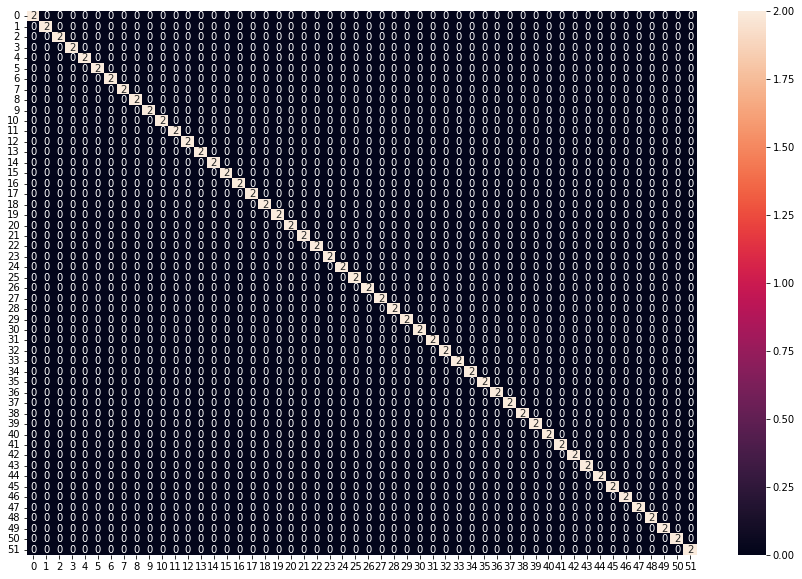

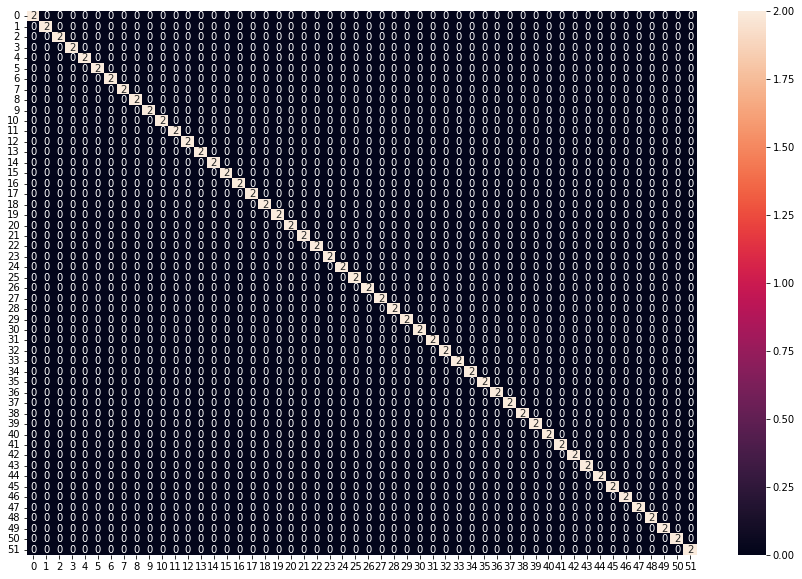

In [ ]:
num_base_models = 20
randomness_param = 8
Mpca = 100
Mlda = 50
is_feature_random = True

train_dataset_tmp_list = [get_train_dataset(imgs_raw, num_per_class=8, is_replace=True) for _ in range(num_base_models)]

train_dataset_label_list = [i[1] for i in train_dataset_tmp_list]
train_dataset_list = [i[0] for i in train_dataset_tmp_list]

# PCA_result_random_list = [PCA(train_dataset_list[i], Mpca, is_feature_random=True) for i in range(num_base_models)]
# PCA_result_nonrandom_list = [PCA(train_dataset_list[i], Mpca, is_feature_random=False) for i in range(num_base_models)]

test_result_LDA_proba_list = []
test_result_LDA_labels_list = []

Ensemble_PCA_LDA(num_base_models, randomness_param, is_feature_random, train_dataset_list, train_dataset_label_list)